Version 1.0.1

# Check your versions

In [1]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm 

for p in [np, pd, scipy, sklearn, lightgbm]:
    print (p.__name__, p.__version__)

numpy 1.15.4
pandas 0.23.4
scipy 1.2.0
sklearn 0.20.2
lightgbm 2.3.1


**Important!** There is a huge chance that the assignment will be impossible to pass if the versions of `lighgbm` and `scikit-learn` are wrong. The versions being tested:

    numpy 1.13.1
    pandas 0.20.3
    scipy 0.19.1
    sklearn 0.19.0
    ligthgbm 2.0.6
    

To install an older version of `lighgbm` you may use the following command:
```
pip uninstall lightgbm
pip install lightgbm==2.0.6
```

# Ensembling

In this programming assignment you are asked to implement two ensembling schemes: simple linear mix and stacking.

We will spend several cells to load data and create feature matrix, you can scroll down this part or try to understand what's happening.

In [2]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load data subset

Let's load the data from the hard drive first.

In [3]:
sales = pd.read_csv('data/sales_train.csv.gz')
shops = pd.read_csv('data/shops.csv')
items = pd.read_csv('data/items.csv')
item_cats = pd.read_csv('data/item_categories.csv')

In [4]:
test = pd.read_csv('data/test.csv.gz')
test['date_block_num'] = 1 + sales['date_block_num'].iloc[-1]

And use only 3 shops for simplicity.

In [5]:
#sales = sales[sales['shop_id'].isin([26, 27, 28])]

# EDA & Data leakage

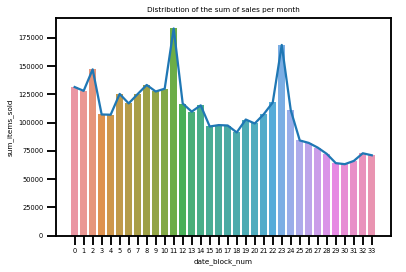

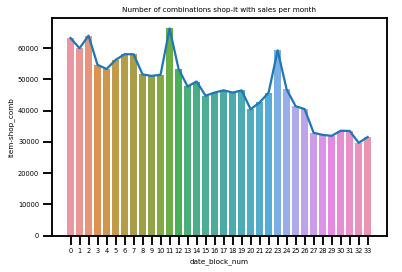

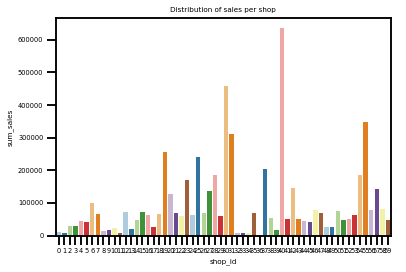

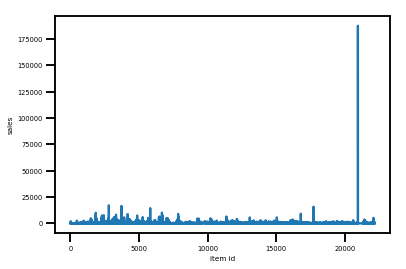

In [11]:
import seaborn as sns

sns.set_context("talk", font_scale=0.4)
sales_month = pd.DataFrame(sales.groupby(['date_block_num']).sum().item_cnt_day).reset_index()
sales_month.columns = ['date_block_num', 'sum_items_sold']
sns.barplot(x ='date_block_num', y='sum_items_sold', 
            data=sales_month.reset_index());
plt.plot(sales_month.sum_items_sold)
plt.title('Distribution of the sum of sales per month')
plt.show()
del sales_month

comb_shop_item = pd.DataFrame(sales[['date_block_num', 'shop_id', 
                                     'item_id']].drop_duplicates().groupby('date_block_num').size()).reset_index()
comb_shop_item.columns = ['date_block_num', 'item-shop_comb']
sns.barplot(x ='date_block_num', y='item-shop_comb', data=comb_shop_item);
plt.plot(comb_shop_item['item-shop_comb']);
plt.title('Number of combinations shop-it with sales per month')
plt.show()
del comb_shop_item

sns.set_context("talk", font_scale=0.4)
sales_item_cat = sales.merge(items, how='left', on='item_id').groupby('item_category_id').item_cnt_day.sum()
sns.barplot(x ='item_category_id', y='item_cnt_day',
            data=sales_item_cat.reset_index(), 
            palette='Paired'
           );
del sales_item_cat

sns.set_context("talk", font_scale=0.4)
sales_month_shop_id = pd.DataFrame(sales.groupby(['shop_id']).sum().item_cnt_day).reset_index()
sales_month_shop_id.columns = ['shop_id', 'sum_sales']
sns.barplot(x ='shop_id', y='sum_sales', data=sales_month_shop_id, palette='Paired')
plt.title('Distribution of sales per shop');
plt.show()
del sales_month_shop_id

sns.set_context("talk", font_scale=0.4)
sales_item_id = pd.DataFrame(sales.groupby(['item_id']).sum().item_cnt_day)
plt.xlabel('item id')
plt.ylabel('sales')
plt.plot(sales_item_id);
plt.show()

# Get a feature matrix

We now need to prepare the features. This part is all implemented for you.

In [5]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.concat([pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32), test])

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':
/usr/local/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago.

In [6]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(['ID'] + index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
#item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

#all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

To this end, we've created a feature matrix. It is stored in `all_data` variable. Take a look:

In [7]:
all_data.head(5)

,ID,date_block_num,item_id,shop_id,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12
4488756,0.0,12,10297,54,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488757,0.0,12,10296,54,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488758,0.0,12,10298,54,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488759,0.0,12,10300,54,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488760,0.0,12,10284,54,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0


# Feature preprocessing

In [8]:
from sklearn import feature_extraction
from IPython.display import display

feature_cnt = 25

tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
items['item_name_len'] = items['item_name'].map(len) #Lenth of Item Description
items['item_name_wc'] = items['item_name'].map(lambda x: len(str(x).split(' '))) #Item Description Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(items['item_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    items['item_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
items.drop(columns='item_name', inplace=True)
display(items.head())

# ------------------------------

tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
item_cats['item_category_name_len'] = item_cats['item_category_name'].map(len)  #Lenth of Item Category Description
item_cats['item_category_name_wc'] = item_cats['item_category_name'].map(lambda x: len(str(x).split(' '))) #Item Category Description Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(item_cats['item_category_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    item_cats['item_category_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
item_cats.drop(columns='item_category_name', inplace=True)
display(item_cats.head())

# ------------------------------

tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
shops['shop_name_len'] = shops['shop_name'].map(len)  #Lenth of Shop Name
shops['shop_name_wc'] = shops['shop_name'].map(lambda x: len(str(x).split(' '))) #Shop Name Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(shops['shop_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    shops['shop_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
shops.drop(columns='shop_name', inplace=True)
display(shops.head())

all_data = pd.merge(pd.merge(all_data, items, how='left', on='item_id'), item_cats, how='left', on='item_category_id')
all_data = downcast_dtypes(pd.merge(all_data, shops, how='left', on='shop_id'))
display(all_data.head())

,item_id,item_category_id,item_name_len,item_name_wc,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24
0,0,40,41,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1,76,68,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.637898,0.0,0.0,0.0,0.0,0.442678,0.0,0.0,0.0,0.403761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.483839
2,2,40,45,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,3,40,47,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,4,40,43,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


,item_category_id,item_category_name_len,item_category_name_wc,item_category_name_tfidf_0,item_category_name_tfidf_1,item_category_name_tfidf_2,item_category_name_tfidf_3,item_category_name_tfidf_4,item_category_name_tfidf_5,item_category_name_tfidf_6,item_category_name_tfidf_7,item_category_name_tfidf_8,item_category_name_tfidf_9,item_category_name_tfidf_10,item_category_name_tfidf_11,item_category_name_tfidf_12,item_category_name_tfidf_13,item_category_name_tfidf_14,item_category_name_tfidf_15,item_category_name_tfidf_16,item_category_name_tfidf_17,item_category_name_tfidf_18,item_category_name_tfidf_19,item_category_name_tfidf_20,item_category_name_tfidf_21,item_category_name_tfidf_22,item_category_name_tfidf_23,item_category_name_tfidf_24
0,0,23,3,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,16,3,0.0,0.0,0.0,0.0,0.780837,0.000000,0.000000,0.000000,0.0,0.0,0.624735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,16,3,0.0,0.0,0.0,0.0,0.000000,0.780837,0.000000,0.000000,0.0,0.0,0.624735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,16,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.780837,0.000000,0.0,0.0,0.624735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,16,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.780837,0.0,0.0,0.624735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,shop_id,shop_name_len,shop_name_wc,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,shop_name_tfidf_7,shop_name_tfidf_8,shop_name_tfidf_9,shop_name_tfidf_10,shop_name_tfidf_11,shop_name_tfidf_12,shop_name_tfidf_13,shop_name_tfidf_14,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,0,29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000
1,1,29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322815,0.0,0.689588,0.648274
2,2,16,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866844,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.498580,0.0,0.000000,0.000000
3,3,30,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000
4,4,24,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.905675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.423972,0.0,0.000000,0.000000


,ID,date_block_num,item_id,shop_id,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,...,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,shop_name_tfidf_7,shop_name_tfidf_8,shop_name_tfidf_9,shop_name_tfidf_10,shop_name_tfidf_11,shop_name_tfidf_12,shop_name_tfidf_13,shop_name_tfidf_14,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,0.0,12,10297,54,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0
1,0.0,12,10296,54,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0
2,0.0,12,10298,54,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0
3,0.0,12,10300,54,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0
4,0.0,12,10284,54,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0


# Train/test split

For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [9]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 34


In [10]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

# First level models 

You need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first. 

### Test meta-features

Firts, we will run *linear regression* on numeric columns and get predictions for the last month.

In [11]:
clips = [0, 20]

lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values).clip(*clips)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))

Test R-squared for linreg is 0.000000


And the we run *LightGBM*.

In [13]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.05, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train.clip(*clips)), int(100 * (0.05 / 0.03)))
pred_lgb = model.predict(X_test).clip(*clips)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

Test R-squared for LightGBM is 0.000000


# Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(bootstrap=0.7, criterion='mse', max_depth=12,
                           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
                           min_impurity_split=None, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=300, n_jobs=4, oob_score=False, random_state=None,
                           verbose=0, warm_start=False)

rf.fit(X_train.values, y_train)
pred_rf = rf.predict(X_test.values).clip(*clips)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_rf))

Test R-squared for linreg is 0.000000


Finally, concatenate test predictions to get test meta-features.

In [17]:
X_test_level2 = np.c_[pred_rf, pred_lgb] 

### Train meta-features

**Now it is your turn to write the code**. You need to implement ***scheme f)*** from the reading material. Here, we will use duration **T** equal to month and **M=15**.  

That is, you need to get predictions (meta-features) from *linear regression* and *LightGBM* for months 27, 28, 29, 30, 31, 32. Use the same parameters as in above models.

In [18]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

In [19]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32, 33]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    trX, teX = all_data.loc[dates<cur_block_num].drop(to_drop_cols, 1), all_data.loc[dates==cur_block_num].drop(to_drop_cols, 1)
    trY, teY = all_data.loc[dates<cur_block_num, 'target'].values, all_data.loc[dates==cur_block_num, 'target'].values
    
    rf.fit(trX.values, trY)
    model = lgb.train(lgb_params, lgb.Dataset(trX, label=trY), 100)
    
    X_train_level2[dates_train_level2 == cur_block_num, 0] = rf.predict(teX.values).clip(*clips)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = model.predict(teX).clip(*clips)
    
    
# Sanity check
#assert np.all(np.isclose(X_train_level2.mean(axis=0), [ 1.50148988,  1.38811989]))

27
28
29
30
31
32
33


Remember, the ensembles work best, when first level models are diverse. We can qualitatively analyze the diversity by examinig *scatter plot* between the two metafeatures. Plot the scatter plot below. 

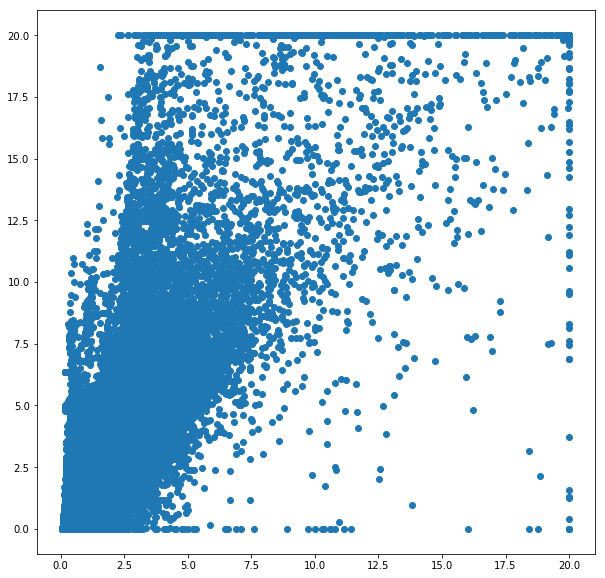

In [20]:
# YOUR CODE GOES HERE

plt.figure(figsize=(10, 10))
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1])
plt.show()

# Ensembling

Now, when the meta-features are created, we can ensemble our first level models.

### Simple convex mix

Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array. Remember, that you need to use train meta-features (not test) when searching for $\alpha$. 

In [21]:
alphas_to_try = np.linspace(0, 1, 1001)

# YOUR CODE GOES HERE
best_alpha = alphas_to_try[np.array([r2_score(y_train_level2, X_train_level2 @ [alpha, 1 - alpha]) for alpha in alphas_to_try]).argmax()]
r2_train_simple_mix = np.array([r2_score(y_train_level2, X_train_level2 @ [alpha, 1 - alpha]) for alpha in alphas_to_try]).max()

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.104000; Corresponding r2 score on train: 0.086064


Now use the $\alpha$ you've found to compute predictions for the test set 

In [22]:
test_preds = pred_rf.clip(*clips)*best_alpha + pred_lgb.clip(*clips)*(1 - best_alpha)
test['item_cnt_month'] = test_preds
test[['ID', 'item_cnt_month']].to_csv('submission_averaging.csv', index=False)

### Stacking

Now, we will try a more advanced ensembling technique. Fit a linear regression model to the meta-features. Use the same parameters as in the model above.

In [23]:
rf.fit(X_train_level2, y_train_level2)

ValueError: max_features must be in (0, n_features]

Compute R-squared on the train and test sets.

In [ ]:
train_preds = rf.predict(X_train_level2).clip(*clips)
r2_train_stacking = r2_score(y_train_level2, train_preds)

test_preds = rf.predict(np.vstack((pred_rf, pred_lgb)).T).clip(*clips)

test_preds = rf.predict(np.vstack((pred_rf, pred_lgb)).T).clip(*clips)
test['item_cnt_month'] = test_preds
test[['ID', 'item_cnt_month']].to_csv('submission_stacking.csv', index=False)

print('Train R-squared for stacking is %f' % r2_train_stacking)

In [ ]:
2+2